In [72]:
import os
import torch
from scipy import signal
import heartpy.filtering
import numpy as np
import sys
import wfdb
from ecg_qc.ecg_qc import EcgQc
import pandas as pd
import logging
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [73]:

database_path = "mit-bih-normal-sinus-rhythm-database-1.0.0/" # Path to the MIT-BIH Normal Sinus Rhythm Database
data_files = [database_path + file for file in os.listdir(database_path) if ".dat" in file]
save_path = '/save_path/' # Path to save the processed dataset


In [91]:
names_samples = []
fs = 128
win = 5
fs_new = 128
signal_quality = []
part = 2

In [4]:
## Loop ecg.bin files
for participant, file in enumerate(data_files):
    counter = 0

    if participant==part:

        logging.critical("Participant: " + str(participant) + "/" + str(len(data_files)))

        data = wfdb.rdsamp(data_files[part][:-4])[0][:,0]
        ECG_SIGNAL = torch.Tensor(data)  # Final numpy array containing full days record

        # windows of 10 s
        pbar = tqdm(total=data.size/fs)
        for i in range(0, data.size, fs):
            min_limit = i
            max_limit = i + win * fs

            if (max_limit <= data.size):

                # Save path
                counter = counter + 1
                name_sample = "{}_{:012d}".format(participant, counter)
                names_samples.append(name_sample)

                window_complete = ECG_SIGNAL[min_limit:max_limit]

                # Median Filter
                med = signal.medfilt(window_complete, 3)

                # Bandpass Filter
                filt = heartpy.filtering.filter_signal(med, [0.5, 30], fs, order=2,
                                                        filtertype='bandpass')

                # Signal Quality
                signal_quality_now = []
                win_intra = 1
                for k in range(win_intra * fs, window_complete.shape[0] + 1, win_intra * fs):
                    min_limit = k - win_intra * fs
                    max_limit = k
                    window_complete_intra = filt[min_limit:max_limit]
                    ecg_qc = EcgQc(model_file='xgb_9s.joblib', sampling_frequency=fs, normalized=False)
                    signal_quality_now.append(ecg_qc.get_signal_quality(window_complete_intra))

                signal_quality.append(np.mean(signal_quality_now))
                pbar.update(1)

CRITICAL:root:Participant: 3/18
  0%|          | 213/86336.0 [00:34<3:52:37,  6.17it/s]

KeyboardInterrupt: 

In [ ]:
np.save(f'signal_quality_{part+1}.npy', np.array(signal_quality))

In [92]:
# Load signal_quality from a file named 'signal_quality_2.npy'
signal_quality_2_path = os.path.join(f'signal_quality_{part+1}.npy')
signal_quality = np.load(signal_quality_2_path)
print(signal_quality)

[1. 1. 1. ... 0. 0. 0.]


In [93]:
is_quality = signal_quality < 0.6
print(is_quality)

[False False False ...  True  True  True]


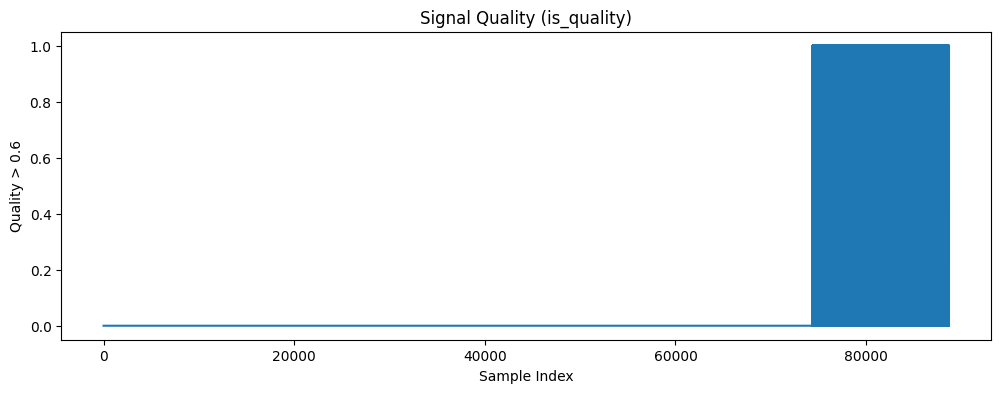

In [94]:
plt.figure(figsize=(12, 4))
plt.plot(is_quality)
plt.title('Signal Quality (is_quality)')
plt.xlabel('Sample Index')
plt.ylabel('Quality > 0.6')
plt.show()

In [95]:
arteffects_intervals = []
min_limit = 0
max_limit = 0

for i,is_arteffect in enumerate(is_quality):

    if is_arteffect==True and (max_limit/fs) <=i:
        min_limit = i*fs
        max_limit = (i+5)*fs
        condition = True
        k = i
        while condition:
            k = k + 1
            if k<=len(is_quality)-1:
                if is_quality[k]==True:
                    max_limit = max_limit + fs
                else:
                    condition = False
            else:
                break
        arteffects_intervals.append((min_limit, max_limit))


In [96]:
data = wfdb.rdsamp(data_files[part][:-4])[0][:,0]
ECG_SIGNAL = torch.Tensor(wfdb.rdsamp(data_files[part][:-4])[0][:,0])

In [97]:
# Median Filter
ECG_SIGNAL = signal.medfilt(ECG_SIGNAL, 3)

# Bandpass Filter
ECG_SIGNAL = heartpy.filtering.filter_signal(ECG_SIGNAL, [0.5, 30], fs, order=2,
                                        filtertype='bandpass')


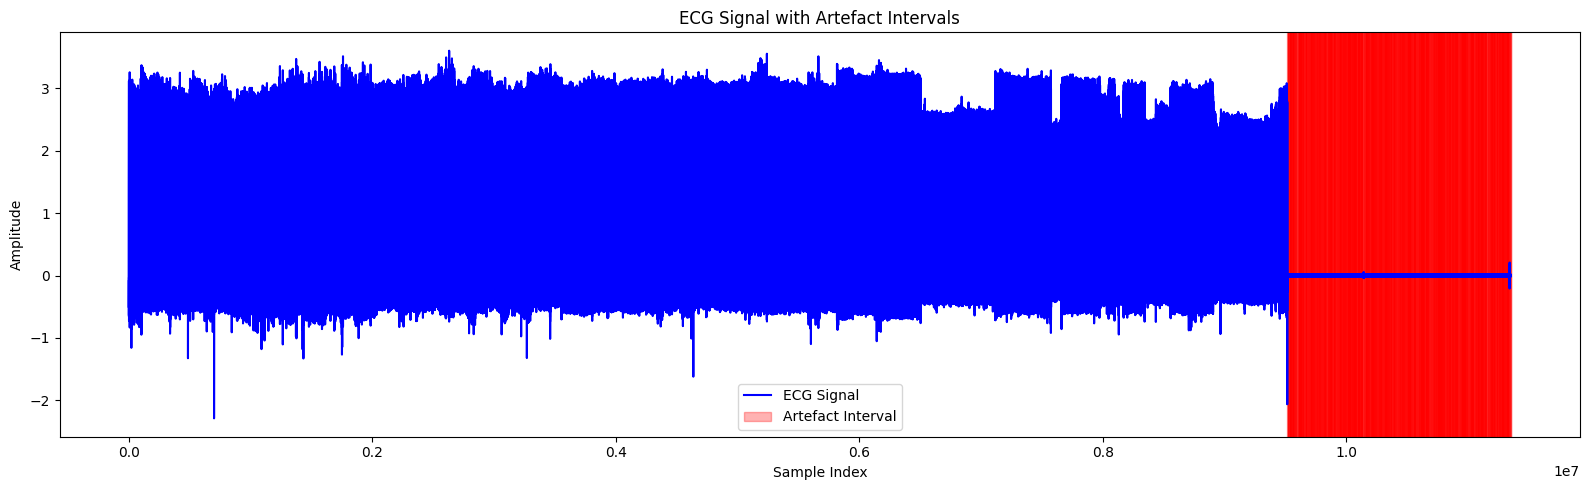

In [98]:
plt.figure(figsize=(16, 5))
plt.plot(ECG_SIGNAL, label='ECG Signal', color='blue')

for start, end in arteffects_intervals:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Artefact Interval' if start == arteffects_intervals[0][0] else "")

plt.title('ECG Signal with Artefact Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

### Data Preparation for Model fitting

In [99]:
X = []
Y = []
counter = 0
pbar_2 = tqdm(total=data.size/fs)
for i in range(0, data.size, fs):
    min_limit = i
    max_limit = i + win * fs

    if (max_limit <= data.size) and not(is_quality[counter]):
        window = ECG_SIGNAL[min_limit:max_limit]
        X.append(window)
        Y.append(1)
        counter = counter + 1
    pbar_2.update(1)
X = np.array(X)
Y = np.array(Y)

100%|██████████| 90000/90000.0 [08:38<00:00, 173.53it/s]   
 62%|██████▏   | 55017/88704.0 [00:00<00:00, 125087.00it/s]

In [100]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (74347, 640)
Y shape: (74347,)


In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Modeling

In [ ]:
from sklearn.mixture import GaussianMixture

In [25]:
n_components = 6
gmm_model = GaussianMixture(n_components=n_components, 
                            covariance_type='full', 
                            random_state=42)

In [107]:
import joblib

In [102]:
print(f"Training Gaussian Mixture Model with {n_components} components...")


gmm_model.fit(X_train)

Training Gaussian Mixture Model with 6 components...


100%|██████████| 88704/88704.0 [00:16<00:00, 125087.00it/s]

,n_components,6
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [108]:
# Save the model
joblib.dump(gmm_model, "gmm_model.pkl")

['gmm_model.pkl']

In [ ]:
# Load the model later
# gmm_model = joblib.load("gmm_model.pkl")

In [103]:
log_likelihoods = gmm_model.score_samples(X_test)

In [104]:
print(f"\nExample log-likelihoods for a few 'normal' test samples:")
print(log_likelihoods[:5])


Example log-likelihoods for a few 'normal' test samples:
[1833.58824608 1423.84235186 1568.83719898 1825.27520718 1638.93472315]


In [105]:
log_likelihoods.shape

(14870,)

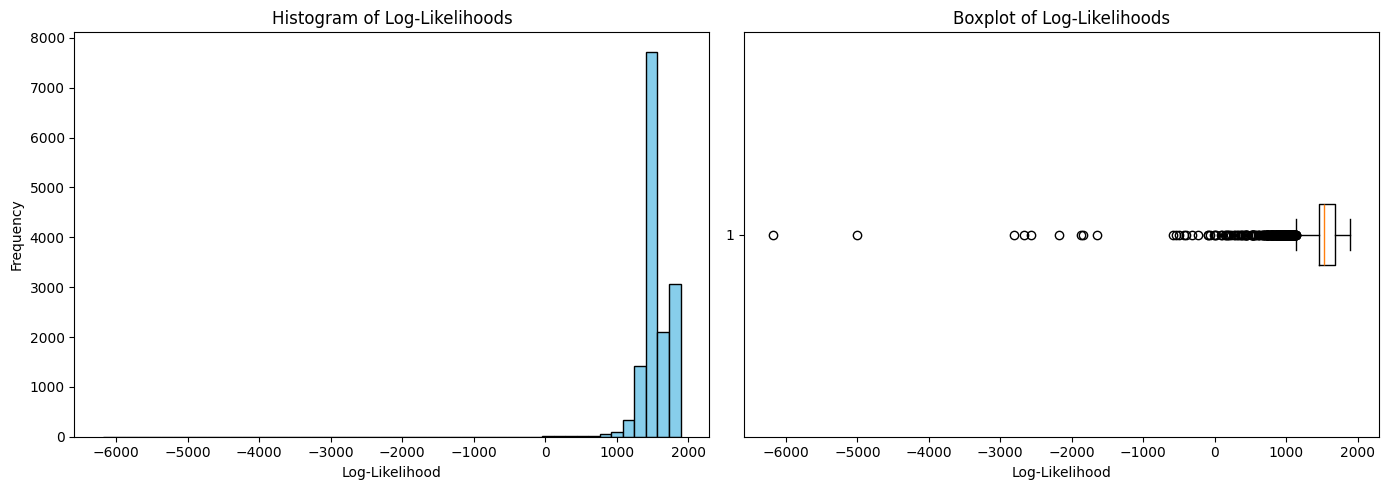

In [106]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(log_likelihoods, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Log-Likelihoods')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(log_likelihoods, vert=False)
plt.title('Boxplot of Log-Likelihoods')
plt.xlabel('Log-Likelihood')

plt.tight_layout()
plt.show()